# Microtubule Fitter

Steps:

- Discretize the initial line.
- Fit Gaussian to each points to the initial line normal vector crossing the point.
- Run linear regression on the previous fit's `mu` values.
- From those points, get the line profile with a certain thickness.
- Fit the line profile to an half Gaussian or the error function.
- Done :-)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import json
import sys
sys.path.append("../../")

import anamic

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
from scipy import ndimage

data_dir = Path('/home/hadim/Drive/Data/Fake Microtubules/anamic/taper_length/')

../../anamic/transformations.py:1916: UserWarning: No module named 'anamic._transformations'
  warnings.warn(str(err))


In [3]:
condition = "taper_length_nm-0000"
fnames = sorted(list((data_dir / condition).glob("*.tif")))

index = 0
fname = fnames[index]

# Open the image
im = tifffile.imread(str(fname))

# Load metadata
metadata = json.load(open(fname.with_suffix('.json')))

# Get microtubule tip coordinates
tip_start = np.array(metadata['tip_start'])
tip_end = np.array(metadata['tip_end'])

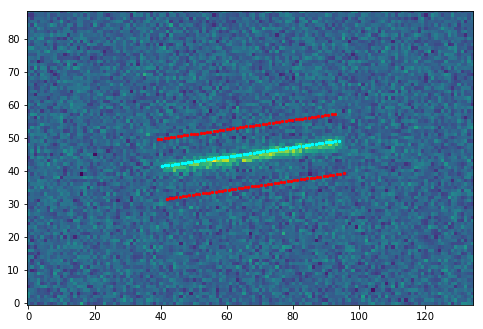

In [8]:
args = {}
args['length_spacing'] = 1  # pixel
args['line_thickness'] = 2000 / metadata['pixel_size'] # pixel
args['width_spacing'] = 5  # pixel

lines = anamic.fitter.get_thick_line(tip_start, tip_end, **args)

# Check the new points.
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(im, interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')

ax.scatter(lines[1, 0], lines[0, 0], color='red', s=20, marker=".")
ax.scatter(lines[1, -1], lines[0, -1], color='red', s=20, marker=".")

middle_index = int(lines.shape[1] / 2)
ax.scatter(lines[1, middle_index], lines[0, middle_index], color='cyan', s=20, marker=".")
ax.scatter(lines[1, 3], lines[0, 3], color='cyan', s=20, marker=".")

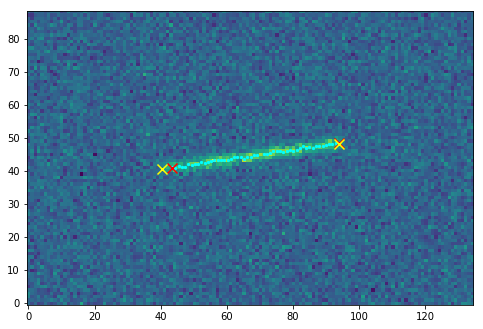

In [9]:
fitted_line = anamic.fitter.perpendicular_line_fit(lines, im, length_spacing=0.1, fit_threshold=0.15)

# Now we fit the best line from those points
a, b = np.polyfit(fitted_line[:, 1], fitted_line[:, 0], deg=1)
new_point1 = np.array([a * fitted_line[0, 1] + b, fitted_line[0, 1]])
new_point2 = np.array([a * fitted_line[-1, 1] + b, fitted_line[-1, 1]])

# This the new line defining the microtubule
new_line = np.array([new_point1, new_point2])

# Check the fitted points
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(im, interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')

initial_line = np.array([tip_start, tip_end])

ax.scatter(fitted_line[:, 1], fitted_line[:, 0], color='cyan', s=20, marker=".")
ax.scatter(new_line[:, 1], new_line[:, 0], color='red', s=100, marker="x")
ax.scatter(initial_line[:, 1], initial_line[:, 0], color='yellow', s=100, marker="x")

In [10]:
# Now we fit the microtubule using a line profile with a defined thickness.

# We define a new line we are going to use for the fitting process
pixel_size = metadata['pixel_size']
offset_start = 4000  # nm
offset_end = 2000  # nm
offset_start_pixel = offset_start / pixel_size
offset_end_pixel = offset_end / pixel_size

line = np.array([tip_start, tip_end])

# Calculate the vector of the line and its norm
vec = tip_end - tip_start

# Get the coordinates of the points we'll use
# to for line fitting.
start_point = anamic.geometry.get_point_from_vector(-vec, tip_end, offset_start_pixel)
end_point = anamic.geometry.get_point_from_vector(vec, tip_end, offset_end_pixel)
line_fit_tips = np.array([start_point, end_point])

In [11]:
line_fit_tips

array([[ 43.11152055,  58.00363188],
       [ 50.84423973, 111.99818406]])

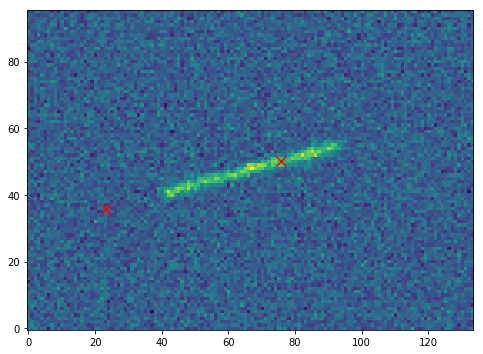

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.imshow(im, interpolation='none', origin=[0, 0], cmap='viridis')
ax.set_aspect('equal')
ax.scatter(line_fit_tips[:, 1], line_fit_tips[:, 0], color='red', s=100, marker="x")

In [13]:
fit_params = {}
fit_params['length_spacing'] = 0.1
fit_params['line_thickness'] = 400 / metadata["pixel_size"]
fit_params['width_spacing'] = 0.1

x_profile, y_profile, fit_result, fit_func = anamic.fitter.tip_line_fit(line_fit_tips[0], line_fit_tips[1], im, **fit_params)
fit_values = fit_result.values
fit_values

{'mu': 36.75328219546779,
 'sigma': 1.1856003291837638,
 'mt': 0.17583434223771088,
 'bg': 0.775047742219092}

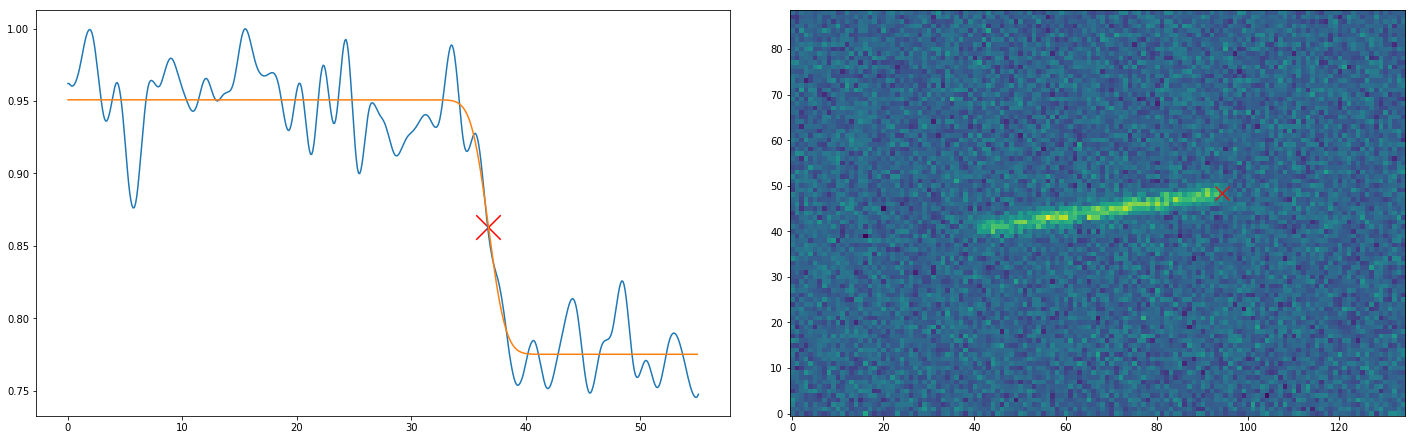

In [14]:
x = np.arange(x_profile[0], x_profile[-1], 0.1)
y_fitted = fit_func(x, **fit_values)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 6), constrained_layout=True)
ax1.plot(x_profile, y_profile, label='data')
ax1.plot(x, y_fitted, label='fit')

mu = fit_values['mu']
ax1.scatter(mu, fit_func(mu, **fit_values), color='red', s=600, marker='x')

ax2.imshow(im, interpolation='none', origin=[0, 0], cmap='viridis')
ax2.set_aspect('equal')

tip_position = anamic.geometry.get_point_from_vector(vec, line_fit_tips[0], mu)
ax2.scatter(tip_position[1], tip_position[0], color='red', s=200, marker="x", alpha=0.8)